# Restauração de Imagem com EM e Soft-Thresholding (L1)

**Autor:** Gabriel Ligabô

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.fft import fft2, ifft2
import pywt
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Carregar a imagem original na escala 0-255 para referência
x_true_255 = data.camera().astype(np.float64)
h, w = x_true_255.shape

# Normalizar a imagem para a escala 0-1 para todos os cálculos
x_true_01 = x_true_255 / 255.0

# 1. Definir o kernel de borramento
psf_size = 9
psf = np.ones((psf_size, psf_size)) / (psf_size**2)

# 2. Preparar a FFT do kernel para uma convolução eficiente
pad_h = (h - psf_size) // 2
pad_w = (w - psf_size) // 2
psf_padded = np.pad(psf, ((pad_h, h - psf_size - pad_h), (pad_w, w - psf_size - pad_w)))
H_fft = fft2(np.fft.ifftshift(psf_padded))

# 3. Aplicar o borrão à imagem
x_blurred_01 = np.real(ifft2(fft2(x_true_01) * H_fft))

# 4. Adicionar ruído gaussiano
# Usandoo os mesmos parâmetros do artigo
sigma_sq_255 = 0.308
sigma_sq_01 = sigma_sq_255 / (255.0**2)
sigma_01 = np.sqrt(sigma_sq_01) 

# 5. Gerar a imagem degradada final
np.random.seed(0) # Reprodutibilidade
noise = np.random.normal(0, sigma_01, x_true_01.shape)
y_degraded = x_blurred_01 + noise
y_degraded = np.clip(y_degraded, 0, 1)

In [3]:
def wiener_filter_init(y, H_fft, noise_var):
    """
    Função de INICIALIZAÇÃO com Filtro de Wiener e escala correta.
    """
    prior_signal_power_255 = 1000.0
    prior_signal_power_01 = prior_signal_power_255 / (255.0**2)
    regularization_term = noise_var / prior_signal_power_01
    G = np.conj(H_fft) / (np.abs(H_fft)**2 + regularization_term)
    x_init = np.real(ifft2(fft2(y) * G))
    return np.clip(x_init, 0, 1)

def soft_threshold_denoiser(coeffs, alpha, lambda_):
    """
    Função de DENOISING (M-STEP) com SOFT-THRESHOLDING.
    """
    threshold = lambda_ * alpha
    coeffs_thresh = []
    for level_tuple in coeffs:
        cA, (cH, cV, cD) = level_tuple
        cH_thresh = pywt.threshold(cH, threshold, mode='soft')
        cV_thresh = pywt.threshold(cV, threshold, mode='soft')
        cD_thresh = pywt.threshold(cD, threshold, mode='soft')
        coeffs_thresh.append((cA, (cH_thresh, cV_thresh, cD_thresh)))
    return coeffs_thresh

def em_restoration(y, H_fft, sigma, iterations, lambda_, wavelet='haar', level=4):
    """
    Função PRINCIPAL do algoritmo
    """
    alpha = sigma
    x_hat = wiener_filter_init(y, H_fft, sigma**2)
    
    best_snri = -np.inf
    best_x_hat = x_hat.copy()
    
    snri_history = []
    psnr_degraded = psnr(x_true_01, y)
    
    initial_psnr = psnr(x_true_01, x_hat)
    print(f"PSNR após inicialização com Wiener: {initial_psnr:.2f} dB (SNRI inicial: {initial_psnr - psnr_degraded:.2f} dB)")
    
    best_snri = initial_psnr - psnr_degraded
    
    H_conj_fft = np.conj(H_fft)
    
    print("Iniciando restauração com Parada Antecipada")
    for i in range(iterations):
        # E-step
        Hx_hat = np.real(ifft2(fft2(x_hat) * H_fft))
        residual = y - Hx_hat
        HT_residual = np.real(ifft2(fft2(residual) * H_conj_fft))
        z_hat = x_hat + HT_residual
        
        # M-step
        coeffs = pywt.swt2(z_hat, wavelet, level=level)
        coeffs_thresh = soft_threshold_denoiser(coeffs, alpha, lambda_)
        x_hat_new = pywt.iswt2(coeffs_thresh, wavelet)
        
        x_hat = np.clip(x_hat_new, 0, 1)
        
        current_psnr = psnr(x_true_01, x_hat)
        current_snri = current_psnr - psnr_degraded
        snri_history.append(current_snri)
        
        if current_snri > best_snri:
            best_snri = current_snri
            best_x_hat = x_hat.copy()
            print(f'Iteração {i+1}/{iterations}, Novo Pico de SNRI: {best_snri:.2f} dB')
        
    return best_x_hat, snri_history

### Passo 3: Execução e Análise

Com todas as ferramentas prontas, vamos definir os parâmetros do nosso experimento e executar o algoritmo de restauração.

In [4]:
# Hiperparâmetros
ITERATIONS = 80
WAVELET = 'haar'
LEVELS = 4
LAMBDA = 1

x_restored, history = em_restoration(y_degraded, H_fft, sigma_01, ITERATIONS, LAMBDA, WAVELET, LEVELS)

psnr_degraded_final = psnr(x_true_01, y_degraded)
psnr_restored_final = psnr(x_true_01, x_restored)
snri_final = psnr_restored_final - psnr_degraded_final

PSNR após inicialização com Wiener: 26.40 dB (SNRI inicial: 3.21 dB)
Iniciando restauração com Parada Antecipada
Iteração 1/80, Novo Pico de SNRI: 3.44 dB
Iteração 2/80, Novo Pico de SNRI: 3.67 dB
Iteração 3/80, Novo Pico de SNRI: 3.89 dB
Iteração 4/80, Novo Pico de SNRI: 4.10 dB
Iteração 5/80, Novo Pico de SNRI: 4.32 dB
Iteração 6/80, Novo Pico de SNRI: 4.53 dB
Iteração 7/80, Novo Pico de SNRI: 4.73 dB
Iteração 8/80, Novo Pico de SNRI: 4.93 dB
Iteração 9/80, Novo Pico de SNRI: 5.12 dB
Iteração 10/80, Novo Pico de SNRI: 5.31 dB
Iteração 11/80, Novo Pico de SNRI: 5.48 dB
Iteração 12/80, Novo Pico de SNRI: 5.65 dB
Iteração 13/80, Novo Pico de SNRI: 5.81 dB
Iteração 14/80, Novo Pico de SNRI: 5.95 dB
Iteração 15/80, Novo Pico de SNRI: 6.09 dB
Iteração 16/80, Novo Pico de SNRI: 6.21 dB
Iteração 17/80, Novo Pico de SNRI: 6.32 dB
Iteração 18/80, Novo Pico de SNRI: 6.41 dB
Iteração 19/80, Novo Pico de SNRI: 6.49 dB
Iteração 20/80, Novo Pico de SNRI: 6.56 dB
Iteração 21/80, Novo Pico de SNRI: 6

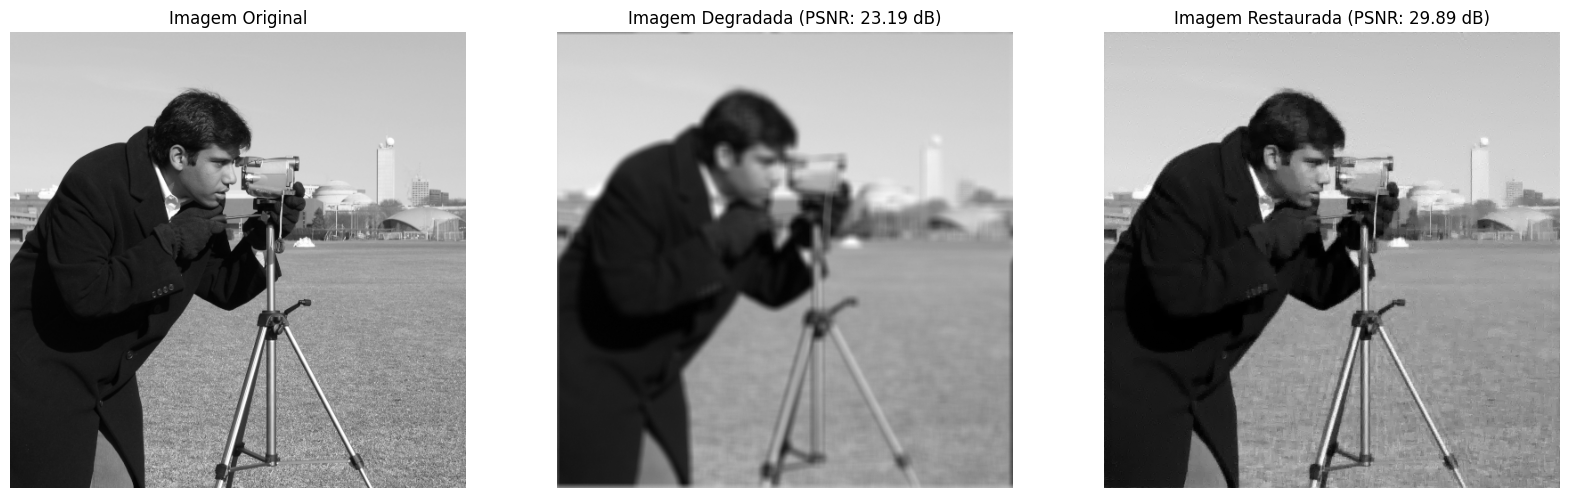

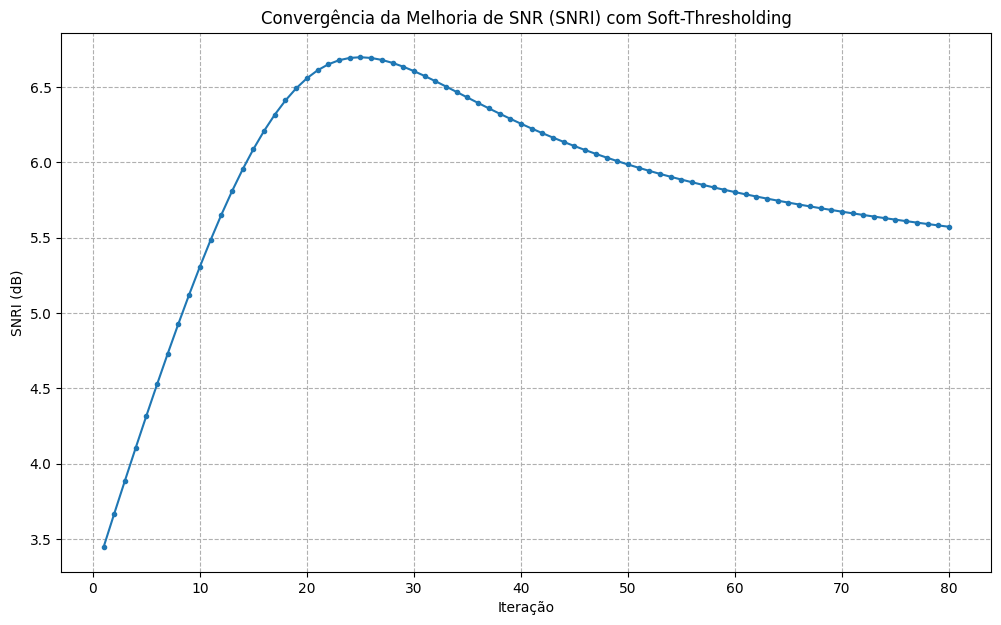

PSNR da imagem degradada: 23.19 dB
PSNR da imagem restaurada: 29.89 dB
Melhoria de SNR (SNRI): 6.70 dB


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].imshow(x_true_01, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(y_degraded, cmap='gray')
axes[1].set_title(f'Imagem Degradada (PSNR: {psnr_degraded_final:.2f} dB)')
axes[1].axis('off')

axes[2].imshow(x_restored, cmap='gray')
axes[2].set_title(f'Imagem Restaurada (PSNR: {psnr_restored_final:.2f} dB)')
axes[2].axis('off')

plt.show()

plt.figure(figsize=(12, 7))
plt.plot(range(1, len(history) + 1), history, marker='.', linestyle='-')
plt.title('Convergência da Melhoria de SNR (SNRI) com Soft-Thresholding')
plt.xlabel('Iteração')
plt.ylabel('SNRI (dB)')
plt.grid(True, linestyle='--')
plt.show()

print(f'PSNR da imagem degradada: {psnr_degraded_final:.2f} dB')
print(f'PSNR da imagem restaurada: {psnr_restored_final:.2f} dB')
print(f'Melhoria de SNR (SNRI): {snri_final:.2f} dB')